In [1]:
# Importing necessary packages

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os # to work with files and directories
import cv2 # to read and resize images
import torch # Pytorch
from torch import nn # PyTorch neural network modules
from torch.utils.data import Dataset, DataLoader, ConcatDataset  # to create and load own datasets.
import torchvision
from torchvision import transforms # to transform images and augment dataset
import torch.nn.functional as F # ReLU, softmax etc...
from tqdm import tqdm # for progress bar
from PIL import Image # to convert numpy images to PIL images for transforms
from sklearn.metrics import f1_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay # to evaluate the results

Downloading the images from https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet

In [3]:
!wget https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/refs/heads/master.zip -O dataset.zip
!unzip -qq dataset.zip

--2025-12-09 09:13:27--  https://github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/archive/refs/heads/master.zip
Resolving github.com (github.com)... 20.205.243.166
Connecting to github.com (github.com)|20.205.243.166|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://codeload.github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/zip/refs/heads/master [following]
--2025-12-09 09:13:27--  https://codeload.github.com/SartajBhuvaji/Brain-Tumor-Classification-DataSet/zip/refs/heads/master
Resolving codeload.github.com (codeload.github.com)... 20.205.243.165
Connecting to codeload.github.com (codeload.github.com)|20.205.243.165|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified [application/zip]
Saving to: ‘dataset.zip’

dataset.zip             [         <=>        ]  86.97M  12.0MB/s    in 9.7s    

2025-12-09 09:13:37 (8.98 MB/s) - ‘dataset.zip’ saved [91198591]



Loading the training and test data

In [4]:
train_img = []
train_labels = []

test_img = []
test_labels = []

path_train = '/content/Brain-Tumor-Classification-DataSet-master/Training'
path_test  = '/content/Brain-Tumor-Classification-DataSet-master/Testing'

img_size = 224 # all images resized to 224×224


# Loading and reading training data
for category in os.listdir(path_train):
    category_path = os.path.join(path_train, category)
    if not os.path.isdir(category_path):
        continue
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is None: # to skip invalid images
            continue
        img = cv2.resize(img, (img_size, img_size)) # resizing the images
        train_img.append(img)
        train_labels.append(category)

# Loading and reading test data
for category in os.listdir(path_test):
    category_path = os.path.join(path_test, category)
    if not os.path.isdir(category_path):
        continue
    for img_name in os.listdir(category_path):
        img_path = os.path.join(category_path, img_name)
        img = cv2.imread(img_path)
        if img is None: # to skip invalid images
            continue
        img = cv2.resize(img, (img_size, img_size)) # resizing the images
        test_img.append(img)
        test_labels.append(category)

# Converting to numpy arrays
train_img = np.array(train_img)
test_img  = np.array(test_img)

# Encoding labels
label_map = {
    'no_tumor': 0,
    'glioma_tumor': 1,
    'meningioma_tumor': 2,
    'pituitary_tumor': 3
}

train_labels_encoded = [label_map[label] for label in train_labels]
test_labels_encoded  = [label_map[label] for label in test_labels]

print("Train shape:", train_img.shape, "Test shape:", test_img.shape)

Train shape: (2870, 224, 224, 3) Test shape: (394, 224, 224, 3)


Defining the dataset

In [5]:
class BrainTumorDataset(Dataset):
    def __init__(self, images, labels, transform=None):
        self.images = images
        self.labels = labels
        self.transform = transform

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx): # to return an image and label at index idx
        img = self.images[idx]
        label = self.labels[idx]

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Converts BGR to RGB as OpenCV loads images as BGR
        img = Image.fromarray(img) # Converts to PIL image (needed for torchvision.transforms).

        if self.transform:
            img = self.transform(img) # Transforms images

        return img, torch.tensor(label, dtype=torch.long) # Converts label to PyTorch tensor

Defining the transforms to augment and normalise the training data and normalise the test data

In [6]:
# Data augmentation transforms for training data
train_transform = transforms.Compose([
    transforms.RandomRotation(20), # rotating
    transforms.RandomHorizontalFlip(), # fliping
    transforms.RandomVerticalFlip(), # fliping
    transforms.ToTensor(), # converting to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # normalizing
])

# Only normalization for test data
test_transform = transforms.Compose([
    transforms.ToTensor(), # converting to tensor
    transforms.Normalize(mean=[0.5,0.5,0.5], std=[0.5,0.5,0.5]) # normalizing
])

Creating the train and test datasets and dataloaders

In [7]:
# Simulate 5x augmentation of training set using ConcatDataset
train_dataset = ConcatDataset([BrainTumorDataset(train_img, train_labels_encoded, transform=train_transform),
    BrainTumorDataset(train_img, train_labels_encoded, transform=train_transform),
    BrainTumorDataset(train_img, train_labels_encoded, transform=train_transform),
    BrainTumorDataset(train_img, train_labels_encoded, transform=train_transform),
    BrainTumorDataset(train_img, train_labels_encoded, transform=train_transform),
    BrainTumorDataset(train_img, train_labels_encoded, transform=train_transform)
])
test_dataset = BrainTumorDataset(test_img, test_labels_encoded, transform=test_transform)


# Dataloaders with batch size 32 (num_workers=2 and pin_memory=True to speed up training in Google Colab)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_dataset, batch_size=32, shuffle=False)

Building the CNN model

In [11]:
class BrainTumorCNN(nn.Module):
    def __init__(self):
        super(BrainTumorCNN, self).__init__()
        # n can be 32, 64, 128 in this analysis
        n = 64
        self.conv1 = nn.Conv2d(3, n, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(n, n, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(n, n, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2,2)

        # After x number of poolings on 224x224 image: 224→112→56→28→14
        # Size of dense layer held constant here (32, 64, 128, 256, 512 or 1024)
        cons = 128
        self.fc1 = nn.Linear(n*28*28, cons)
        self.fc2 = nn.Linear(cons, cons)

        # dropout set to 0.4 (other values investigated: 0.0, 0.2, 0.4, 0.6)
        self.dropout = nn.Dropout(0.6)

        self.output = nn.Linear(cons, 4)  # 4 classes output

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1) # flatten

        x = self.dropout(F.relu(self.fc1(x)))
        x = self.fc2(x)
        x = self.output(x)             # output

        return x

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # to use GPU if available
model = BrainTumorCNN().to(device)

criterion = nn.CrossEntropyLoss() # standard classification loss
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4) # Adam optimizer, learning rate = 0.0001

Training

In [13]:
epochs = 15

scaler = torch.amp.GradScaler() # to have automatic mixed precision for faster training

for epoch in range(epochs):
    model.train()
    running_loss = 0.0

    for images, labels in train_loader:
        # Get inputs and labels
        images = images.to(device)
        labels = labels.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass with mixed precision to make training faster
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)

        # Backward pass and optimize with gradient scaling
        scaler.scale(loss).backward() # backpropagating
        scaler.step(optimizer) # updating optimizer
        scaler.update()

        # Printing statistics
        running_loss += loss.item()

    print(f"Epoch {epoch+1}/{epochs} | Loss: {running_loss/len(train_loader):.4f}")


Epoch 1/15 | Loss: 0.9137
Epoch 2/15 | Loss: 0.7006
Epoch 3/15 | Loss: 0.5991
Epoch 4/15 | Loss: 0.5272
Epoch 5/15 | Loss: 0.4729
Epoch 6/15 | Loss: 0.4215
Epoch 7/15 | Loss: 0.3707
Epoch 8/15 | Loss: 0.3330
Epoch 9/15 | Loss: 0.3129
Epoch 10/15 | Loss: 0.2792
Epoch 11/15 | Loss: 0.2503
Epoch 12/15 | Loss: 0.2329
Epoch 13/15 | Loss: 0.2138
Epoch 14/15 | Loss: 0.1967
Epoch 15/15 | Loss: 0.1895


Evaluation of the model on the test set

Test Accuracy: 70.56%
Test F1 Score: 0.6578
Precision: 0.7624
Recall: 0.7056


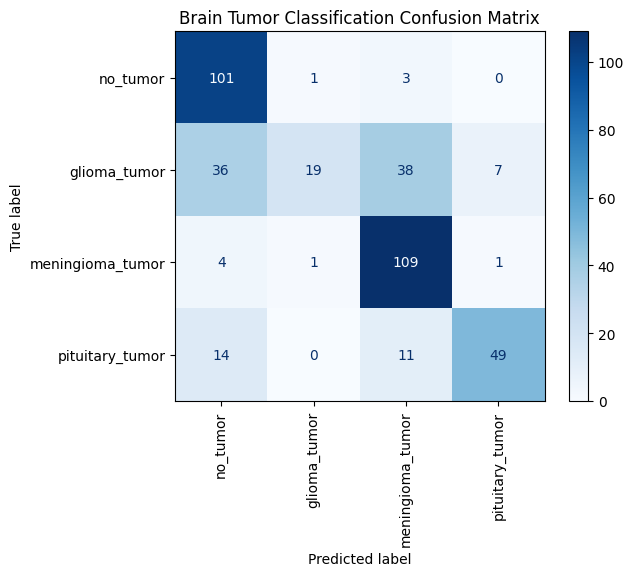

In [15]:
def evaluate(model, dataloader, device, load_weights_path=None, return_preds=False):
    model.to(device)

    if load_weights_path is not None:
        state = torch.load(load_weights_path, map_location=device)
        model.load_state_dict(state)

    model.eval()
    all_preds = []
    all_labels = []
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in dataloader:
            images = images.to(device)
            labels = labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

            correct += (preds == labels).sum().item()
            total += labels.size(0)

    if total == 0:
        raise RuntimeError("Dataloader is empty or labels missing.")

    acc = correct / total
    f1 = f1_score(all_labels, all_preds, average="weighted")
    cm = confusion_matrix(all_labels, all_preds)
    precision = precision_score(all_labels, all_preds, average="weighted")
    recall = recall_score(all_labels, all_preds, average="weighted")

    if return_preds:
        return acc, f1, cm, all_labels, all_preds
    return acc, f1, cm, precision, recall

acc, f1, cm, precision, recall = evaluate(model, test_loader, device)

print(f"Test Accuracy: {acc * 100:.2f}%")
print(f"Test F1 Score: {f1:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")

# Plotting the confusion matrix
class_names = ["no_tumor", "glioma_tumor", "meningioma_tumor", "pituitary_tumor"]

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot(cmap="Blues", xticks_rotation='vertical')
plt.title("Brain Tumor Classification Confusion Matrix")
plt.show()